# <center>Instituto Tecnológico de Estudios Superiores de Occidente</center>



<img style="float: center" src="logo-ITESO-png.png" width="350px" height="125px"/>




#### <center>"Simulación Matemática"</center>


### <center>SIMULACIÓN DE UN PORTAFOLIO DE INVERSIÓN</center>

.



**<center>Profesor: Gabriel Alejando Morales Ruiz</center>**

.



**<center>Leonardo Rodríguez Hernández - 741983</center>**



**<center>Valenzuela Lafarga Mariana - 749770</center>**



**<center>Nancy Woolrich Sorroza - 741983</center>**



.


**<center>22 de abril 2024.</center>**

## <center> Construcción de un portafolio de inversión con programación lineal</center>

### Introducción
    
  
    

### Objetivos

#### 1.1 Objetivo general.

Pronosticar un portaforlio de inversión a un año.

#### 1.2 Objetivos específicos
- Calcular la media y desviación estándar de los rendimientos diarios de las acciones de cada empresa para evaluar su distribución y realizar el pronóstico

- Utilizar el método de aproximación de Montecarlo para simular múltiples escenarios de rendimiento del portafolio de inversión en el próximo año.
- Generar visualizaciones claras y concisas de los resultados del proyecto, incluidas gráficas de desempeño del portafolio y distribuciones de rendimientos simulados.


### Modelo del problema.

Para generar el modelo que pronostique los rendimientos a 1 año se utilizarán los datos diarios del 14 de abril de 2022 a 2023 para poder realizar la comparación con el año 2024 y determinar si el modelo planteado es válido, los datos son sacados de Yahoo finance.

Las acciones con las que se trabajará en el portafolio son:

>- **AAPL:** Apple Inc. diseña, fabrica y comercializa teléfonos inteligentes, computadoras personales, tabletas, dispositivos portátiles y accesorios en todo el mundo.Es la empresa de tecnología más grande del mundo.

>- **AZO:** AutoZone, Inc. vende y distribuye repuestos y accesorios automotrices en Estados Unidos, México y Brasil. La empresa ofrece diversos productos para automóviles, vehículos utilitarios deportivos, camionetas y camiones ligeros.


>- **VRTX:** Ertex Pharmaceuticals Incorporated, una empresa de biotecnología, se dedica al desarrollo y comercialización de terapias para el tratamiento de la fibrosis quística (FQ).


>- **OXY:** Occidental Petroleum Corporation, junto con sus subsidiarias, se dedica a la adquisición, exploración y desarrollo de propiedades de petróleo y gas en los Estados Unidos, Medio Oriente y el norte de África.


>- **WMT:** Walmart Inc. se dedica a la operación de ventas al por menor, al por mayor, otras unidades y comercio electrónico en todo el mundo. La empresa opera a través de tres segmentos: Walmart U.S., Walmart International y Sam's Club.

Se decidieron escoger acciones que fueran medianamente estables con volatilidades no tan altas para que el modelo tenga un menor grado de error. 


In [18]:
import pandas as pd
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
yf.pdr_override()

In [3]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers,
                   start_date=None,
                   end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date
    )
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [4]:
tickers = ["AAPL", "AZO", "VRTX", "OXY", "WMT"]
start_date = "2023-04-14"
end_date= "2024-04-14"
closes = get_adj_closes(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date
)
closes.head()

[*********************100%%**********************]  5 of 5 completed


Ticker,AAPL,AZO,OXY,VRTX,WMT
Date,,,,,
2023-04-14,164.332840,2638.320068,63.675755,333.519989,48.783421
2023-04-17,164.352737,2665.409912,62.154968,327.739990,49.125118
2023-04-18,165.586166,2681.649902,62.214214,325.149994,49.233540
2023-04-19,166.739990,2663.159912,61.690830,328.450012,49.286106
2023-04-20,165.765213,2701.840088,61.256313,329.149994,49.601521


.

- **Modelo**

El siguente paso es obtener el rendimiento diario, para ello se va a observar la distribución de los rendimientos y así comprobar que se asemejen a una distribucion normal.

.

In [5]:
ret = closes.pct_change().dropna()
ret.head()

Ticker,AAPL,AZO,OXY,VRTX,WMT
Date,,,,,
2023-04-17,0.000121,0.010268,-0.023883,-0.017330,0.007004
2023-04-18,0.007505,0.006093,0.000953,-0.007903,0.002207
2023-04-19,0.006968,-0.006895,-0.008413,0.010149,0.001068
2023-04-20,-0.005846,0.014524,-0.007043,0.002131,0.006400
2023-04-21,-0.009781,-0.007562,-0.002579,0.005894,0.005034


En la siguiente gráfica podemos ver que las distribuciones de los rendimientos se asemejan a una normal

array([[<Axes: title={'center': 'AAPL'}>,
        <Axes: title={'center': 'AZO'}>],
       [<Axes: title={'center': 'OXY'}>,
        <Axes: title={'center': 'VRTX'}>],
       [<Axes: title={'center': 'WMT'}>, <Axes: >]], dtype=object)

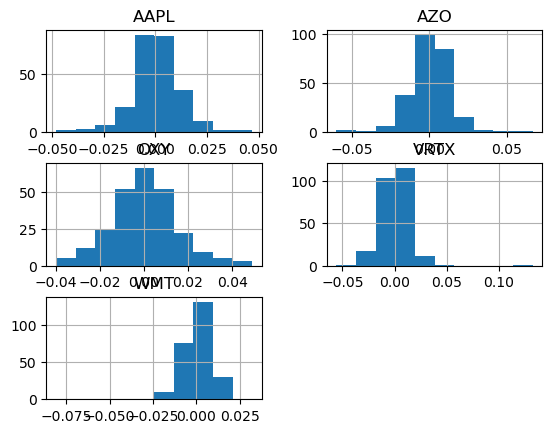

In [6]:
ret.hist()


Ahora se van a obtener los datos de media y desviación estándar para cada uno de estos activos y así tener los parámetros de las distribuciones.

In [7]:
summary_daily = pd.DataFrame({
    "mean": ret.mean(),
    "vol": ret.std()
}).T
summary_daily

Ticker,AAPL,AZO,OXY,VRTX,WMT
mean,0.000362,0.000556,0.000429,0.000803,0.000883
vol,0.012263,0.013593,0.014709,0.015070,0.009479


Una vez obtenidos los parámetros de media y desviación de cada uno de los activos se va a realizar la simulación a 1 año con la siguiente función.

In [8]:
def simR(media,std,start,dias,N):
    sim_R= np.random.normal(media, std,size=(dias,N))+1
    fechas= pd.date_range(start,periods=dias)
    return pd.DataFrame(sim_R,index=fechas)

- **Explicación y limitaciones**

El modelo planteado anteriormente pretende obtener el rendimiento pronosticado del portafolio planteado a 1 año, esto se obtiene mediamente las simulaciones de 365 dias según la media y la desviación de cada activo, después se obtiene el precio final y para determinar rendimiento total.

Las limitaciones que presenta este modelo es que los activos pueden no siempre seguir la misma tendencia, y si son activos muy volátiles su media y su desviación estandar cambia drásticamente de un periodo a otro, por lo que puede no ser un modelo tan certero para todo tipo de activos.

### Solución del modelo



Primeramente se crea una variable para cada desviación estándar y media de cada empresa.

In [40]:
aaplmean = ret["AAPL"].mean()
aaplstd = ret["AAPL"].std()
wmtmean = ret["WMT"].mean()
wmtstd = ret["WMT"].std()
azomean = ret["AZO"].mean()
azostd = ret["AZO"].std()
oxymean = ret["OXY"].mean()
oxystd = ret["OXY"].std()
vrtxmean = ret["VRTX"].mean()
vrtxstd = ret["VRTX"].std()


Se simula para cada Empresa el rendimiento a 1 año:

**APPLE**

In [41]:
#Simulación del rendimiento a 1 año
sim_R_aapl =simR(aaplmean,aaplstd, "2024-04-22", 365, 1000)
sim_R_aapl

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,0.978111,1.000251,1.002045,1.006379,1.016476,1.006943,1.004344,0.992923,0.996265,1.009791,...,0.983848,1.001150,0.985640,1.016379,1.003883,1.020805,0.997786,0.998419,0.986120,1.019237
2024-04-23,1.022094,1.000643,0.990928,0.986574,1.007341,1.018609,1.004337,1.027189,1.008831,1.012536,...,1.003984,0.991222,1.022810,1.001868,0.991094,0.979511,0.997167,1.011561,0.987127,0.993666
2024-04-24,0.996042,0.991080,1.018622,0.988252,1.017368,0.993773,0.988793,1.009071,0.998376,0.999545,...,0.984942,0.999470,1.005103,1.013449,0.991251,0.994260,1.010019,0.984049,1.021195,1.009026
2024-04-25,1.010084,1.005519,1.009554,0.983531,0.990187,1.019786,1.015226,1.021733,1.019539,0.983860,...,0.984589,0.985462,0.992597,1.015878,0.989756,0.992131,1.009161,0.998511,0.994751,1.010717
2024-04-26,0.980492,0.997043,1.006122,0.992251,0.990466,0.997962,1.002665,1.004347,0.994714,1.023569,...,0.970863,1.014889,0.998901,1.031670,1.006300,0.983092,1.000465,0.980433,0.988759,1.013243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,0.996930,1.003499,0.989904,0.996768,0.989594,0.969154,1.020634,1.005336,1.005695,1.003418,...,1.010684,0.985974,0.981002,1.020209,0.981099,1.004800,0.985805,1.010927,0.991300,1.008635
2025-04-18,0.982092,0.998869,0.999914,0.996758,1.005387,1.016747,0.985523,1.004226,0.997260,1.010966,...,0.979092,0.990182,0.990501,0.993915,0.983644,1.012761,1.003126,1.009500,0.995588,0.988841
2025-04-19,0.988798,1.013000,0.982452,1.000672,0.997712,0.999750,1.010549,0.997943,0.977020,1.013774,...,0.998114,0.991265,1.003178,0.981978,0.997413,0.991782,1.000012,1.000288,1.028074,0.982086
2025-04-20,1.007687,1.017049,1.014101,0.994732,0.978639,0.994426,1.004300,0.990491,1.009976,0.991865,...,0.994188,0.985723,0.982115,0.984105,1.012383,0.979802,1.012077,0.997889,0.982810,1.015538


**WALMART**

In [27]:
sim_R_wmt =simR(wmtmean,wmtstd, "2024-04-22", 365, 1000)
sim_R_wmt

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,1.000788,0.998854,0.984221,1.005945,0.996874,1.000479,1.005013,1.009380,1.002328,0.997998,...,1.014288,1.001847,1.000225,1.000572,0.998530,0.995610,0.995800,1.009160,1.014745,1.008057
2024-04-23,0.983596,0.991986,1.001781,0.995845,1.010297,0.986756,1.004620,1.000805,1.015457,0.998231,...,0.988994,0.985909,1.000563,0.997005,0.993420,0.981234,0.999400,1.003358,0.991541,1.005006
2024-04-24,1.010112,1.006404,0.988073,1.011723,1.005691,0.996803,0.997758,1.019437,1.006243,0.986175,...,0.996424,1.001131,1.007500,1.007091,1.012843,0.993756,1.001721,1.001752,0.998269,1.017912
2024-04-25,0.992888,0.986138,0.986218,1.003557,1.012522,0.980490,1.001021,0.991197,1.003511,1.005301,...,1.001015,0.994036,1.006402,0.998544,1.009894,0.985370,0.988555,1.002875,0.995667,0.997263
2024-04-26,1.017250,1.002522,1.005322,0.996806,0.997104,1.003809,1.003179,1.001241,1.011876,0.997399,...,0.990937,1.005707,0.991916,1.006012,0.995362,0.992319,1.000237,0.983462,0.985882,1.001423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,0.994498,0.998544,1.017195,0.999691,0.993865,0.991677,0.994947,0.990275,0.999524,1.006866,...,0.978240,1.006289,0.995078,1.011508,1.004277,1.003725,1.015645,1.002982,1.021318,0.989049
2025-04-18,0.994991,1.023288,1.003488,0.996219,0.997262,0.996480,1.001131,1.002303,1.005336,0.996949,...,0.996201,1.000675,0.989752,1.006858,1.016232,0.978937,1.014817,1.003586,0.997873,0.992259
2025-04-19,0.990500,0.990509,1.012685,0.997272,0.986324,0.999886,1.000720,1.008591,1.002798,1.017306,...,0.992764,0.980950,1.003971,0.995751,0.995151,1.011743,1.001372,1.010575,1.005934,0.991598
2025-04-20,1.001991,1.003948,0.995287,0.997546,1.009004,0.996088,1.008680,0.994592,0.999179,1.009459,...,1.000810,1.001113,1.002401,0.989530,1.022324,1.000627,0.996475,1.014923,0.989468,1.009899


**AUTOZONE**

In [28]:
sim_R_azo =simR(azomean,azostd, "2024-04-22", 365, 1000)
sim_R_azo

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,1.002816,1.025435,0.993150,0.990461,1.001022,1.010801,1.003611,0.985912,1.008092,0.999555,...,0.980826,0.995102,1.002676,0.984513,1.009146,1.003827,0.999603,1.015038,1.003646,1.001756
2024-04-23,0.998379,1.014160,0.999696,0.988429,1.010167,0.985115,0.994427,1.016686,0.991242,1.028294,...,1.007574,0.996057,0.986237,1.016508,1.000293,0.988128,0.998366,0.988051,1.003968,0.989466
2024-04-24,1.013673,1.017508,1.017115,0.999009,1.014373,1.022536,1.006522,0.980583,0.976958,0.986916,...,1.029905,0.986947,1.006641,1.013133,0.988675,1.007232,0.978308,1.000891,1.010859,1.010532
2024-04-25,0.989317,0.999509,1.015559,1.022343,0.987270,1.009787,0.977372,1.014630,0.996797,0.998102,...,1.005306,0.996287,1.018996,0.990842,1.005913,1.012332,0.996974,1.007893,1.008148,1.000405
2024-04-26,1.009369,1.016106,0.996195,1.001937,1.002959,0.990844,1.014595,1.002948,1.036235,0.990717,...,1.001954,0.988771,0.999372,1.026476,0.999825,1.014019,0.998500,0.987552,1.012370,0.978972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,1.000905,1.020620,1.010687,0.981512,0.981378,0.988555,0.993935,0.997758,0.988436,1.026938,...,1.013789,1.020473,1.003893,1.019549,0.992117,0.997316,0.986622,0.997069,1.008219,1.018286
2025-04-18,0.967811,1.002304,0.997427,0.994173,0.992078,1.017879,0.980817,1.005690,0.990282,0.980195,...,1.005275,1.005260,0.994933,1.017466,1.005859,0.998042,1.005702,1.029907,0.997762,0.997767
2025-04-19,0.980602,0.984189,0.982774,1.006959,1.006615,0.983118,0.985270,0.998933,0.997042,0.994549,...,0.984612,0.997801,0.989732,1.031070,0.988575,1.018558,1.003774,0.990886,0.999486,1.004171
2025-04-20,0.997522,1.010507,0.992948,0.987976,0.996915,0.994917,0.982879,1.012779,0.969816,0.999845,...,0.989341,1.027856,1.007251,0.993831,1.004787,0.993252,0.989839,0.989756,1.014985,1.007553


**ERTEX PHARMACEUTICALS**

In [29]:
sim_R_vrtx =simR(vrtxmean,vrtxstd, "2024-04-22", 365, 1000)
sim_R_vrtx

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,1.012921,1.021055,1.009158,1.025175,0.998196,0.975438,1.002764,0.999368,0.997391,1.016083,...,0.993046,0.995603,0.994798,0.967863,1.016205,1.029052,0.990380,1.012630,1.008122,1.003073
2024-04-23,1.022149,1.012636,0.987032,0.991397,0.985699,1.022184,1.008692,1.016971,0.988512,0.990624,...,0.989846,1.024334,0.981054,1.019792,1.010163,0.995554,1.008090,0.998590,0.991202,1.007898
2024-04-24,0.975341,0.992709,1.009860,1.006335,0.991004,1.014081,0.988873,0.982854,1.011141,0.991119,...,1.001686,0.995599,0.989743,1.008660,1.007696,0.988644,0.973926,1.001358,1.038055,1.005471
2024-04-25,1.016000,1.014234,0.999948,1.003155,0.985457,1.022628,1.001635,1.007142,1.024633,0.990629,...,1.009440,1.009125,1.023438,1.025237,1.005008,0.999834,1.001933,1.019539,1.010830,0.992213
2024-04-26,1.001422,0.994016,1.029059,1.020192,0.993011,0.971679,1.005405,0.999935,0.986016,1.003363,...,0.983131,0.990141,1.020457,1.000752,0.984434,0.995470,1.004450,1.008652,0.992782,1.019815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,0.993928,1.019004,0.981162,1.019731,0.979205,0.988948,0.980231,0.995022,0.963599,1.009078,...,1.001534,0.989618,1.004305,0.998994,1.001341,0.979985,1.001563,1.000108,0.997674,1.003892
2025-04-18,1.004689,1.005846,0.999374,1.006595,0.993298,1.005846,1.021942,1.006899,1.033788,1.039257,...,0.997986,0.993546,0.975352,0.981242,0.995027,1.014975,1.004427,1.011981,0.994695,1.013416
2025-04-19,1.020207,0.996778,0.980310,1.008287,0.989474,1.010745,1.003074,0.989934,1.004922,0.985219,...,0.971199,0.992100,1.005829,1.016434,0.994363,0.981597,1.012249,0.983920,0.979050,1.015221
2025-04-20,1.001536,1.006216,1.001844,1.004248,0.992248,0.984014,1.005269,1.002297,0.976184,0.992487,...,1.005222,0.997317,1.023437,1.016423,1.014419,0.993720,0.968917,1.008361,1.009862,1.006464


**OCCIDENTAL PETROLEUM CORPORATION**

In [30]:
sim_R_oxy =simR(oxymean,oxystd, "2024-04-22", 365, 1000)
sim_R_oxy

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,0.982817,1.004075,1.003496,0.994560,0.999091,1.023781,1.007210,0.966732,1.019511,0.983530,...,0.994812,1.024253,1.011491,0.973206,0.989535,0.985204,0.989990,0.991391,1.018909,1.015825
2024-04-23,0.981024,1.013179,0.997470,0.998564,1.000616,0.982531,0.991069,0.989286,0.992107,1.027328,...,0.987340,0.990339,0.998630,1.000429,1.006287,0.987942,1.006157,1.030903,0.988880,0.991210
2024-04-24,1.001578,1.012836,1.006682,1.019376,0.988984,0.977886,1.005426,0.970897,1.003227,1.003995,...,1.003750,1.017824,0.992486,0.995698,0.994446,0.998295,0.979197,0.996888,1.003314,0.997159
2024-04-25,0.996268,0.990981,0.977147,1.005868,1.054854,1.014379,1.011778,1.003722,0.989945,1.015216,...,1.021178,0.996252,0.986742,0.992709,0.989757,0.973898,0.996374,1.010490,0.989857,1.007874
2024-04-26,1.002800,0.982271,0.975642,0.999274,1.013666,1.007970,1.024071,1.004216,0.997058,1.004080,...,0.998251,0.989804,0.987933,1.033244,0.999734,1.010314,1.011488,0.965869,1.002183,1.001241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,0.995478,1.004225,1.004324,0.988060,1.022452,0.990432,0.977775,0.981454,0.992936,1.018108,...,1.021145,0.996953,0.986209,1.008684,0.987563,0.989351,1.013162,0.952767,1.016312,1.022292
2025-04-18,1.012104,0.989730,0.993868,0.996435,1.003739,1.001592,1.016160,0.988186,1.000673,0.995382,...,0.992126,1.029160,1.017742,1.001256,1.010150,0.988503,1.003673,1.038033,1.000059,0.985254
2025-04-19,0.995183,1.004117,0.982006,1.011114,0.996284,1.001400,0.994554,0.998729,0.969691,1.004143,...,1.024106,0.981602,0.988276,0.984842,0.989541,1.000248,1.004896,0.994352,1.006152,1.025427
2025-04-20,1.011254,1.016402,0.993787,0.997130,0.991065,1.014539,1.004879,1.006567,1.012259,1.007476,...,1.008736,1.003002,1.018383,0.986754,1.019451,1.003781,1.021268,0.990477,1.006016,1.005580


In [31]:
ret.iloc[-1]

Ticker
AAPL    0.008627
AZO    -0.014780
OXY    -0.003610
VRTX   -0.009195
WMT     0.000832
Name: 2024-04-12 00:00:00, dtype: float64

**Precios de cierre promedio**

Apple


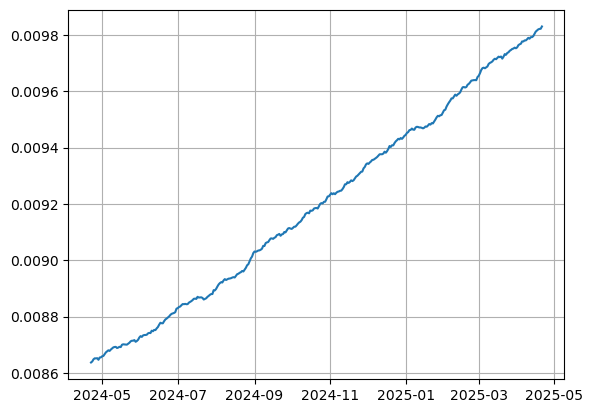

In [42]:
print("Apple")
precios_cierre_aapl=sim_R_aapl.cumprod()*0.008627
mean_aapl = precios_cierre_aapl.mean(axis=1)
plt.plot(mean_aapl)
plt.grid()

Walmart


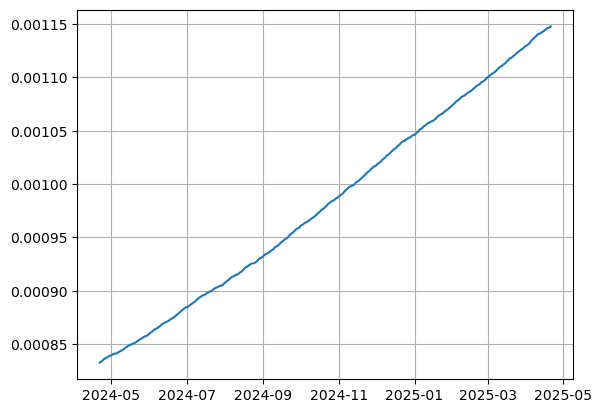

In [43]:
print("Walmart")
precios_cierre_wmt=sim_R_wmt.cumprod()*0.000832
mean_wmt = precios_cierre_wmt.mean(axis=1)
plt.plot(mean_wmt)
plt.grid()

AutoZone


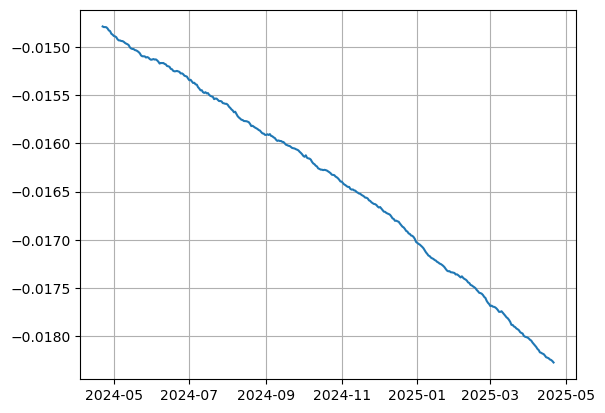

In [44]:
print("AutoZone")
precios_cierre_azo=sim_R_azo.cumprod()*-0.014780
mean_azo = precios_cierre_azo.mean(axis=1)
plt.plot(mean_azo)
plt.grid()

Occidental Petroleum


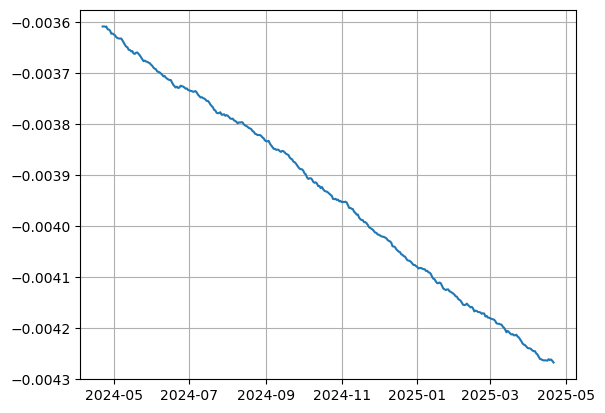

In [45]:
print("Occidental Petroleum")
precios_cierre_oxy=sim_R_oxy.cumprod()*-0.003610
mean_oxy = precios_cierre_oxy.mean(axis=1)
plt.plot(mean_oxy)
plt.grid()

Ertex Pharmaceutics


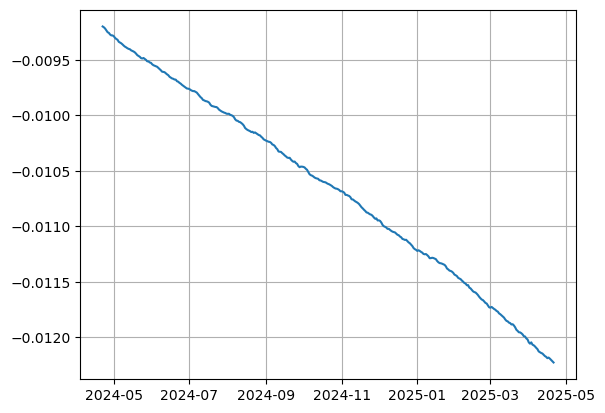

In [47]:
print("Ertex Pharmaceutics")
precios_cierre_vrtx=sim_R_vrtx.cumprod()*-0.009195
mean_vrtx = precios_cierre_vrtx.mean(axis=1)
plt.plot(mean_vrtx)
plt.grid()

**PROBABILIDAD DE AUMENTO DEL 20% EN EL SIGUIENTE AÑO**

In [37]:
# Probabilidad que el dinero crezca un 20%

prob_aapl = ((sim_R_aapl.cumprod()*0.008627*1.20 > 0.008627).mean(axis=1)).mean()*100
prob_wmt = ((sim_R_wmt.cumprod()*0.000832*1.20 > 0.000832).mean(axis=1)).mean()*100
prob_oxy = ((sim_R_oxy.cumprod()*-0.003610*1.20 > -0.003610).mean(axis=1)).mean()*100
prob_azo = ((sim_R_azo.cumprod()*-0.014780*1.20 > -0.014780).mean(axis=1)).mean()*100
prob_vrtx = ((sim_R_vrtx.cumprod()*-0.009195*1.20 > -0.009195).mean(axis=1)).mean()*100

print("APPLE:",prob_aapl,"%")
print("WALMART:",prob_wmt,"%")
print("AUTOZONE:",prob_azo,"%")
print("OCCIDENTAL PETROLEUM:",prob_oxy,"%")
print("ERTEX PHARMACEUTICS:",prob_vrtx,"%")


APPLE: 93.64136986301371 %
WALMART: 99.67013698630137 %
AUTOZONE: 6.066301369863012 %
OCCIDENTAL PETROLEUM: 8.52027397260274 %
ERTEX PHARMACEUTICS: 5.186301369863014 %


## Comparación con el año anterior (2023)

Para observar el crecimiento o decrecimiento de las acciones se compara con los del año anterior.

In [54]:
sim_R_aapl23 =simR(aaplmean,aaplstd, "2023-04-22", 365, 1000)
sim_R_wmt23 =simR(wmtmean,wmtstd, "2023-04-22", 365, 1000)
sim_R_azo23 =simR(azomean,azostd, "2023-04-22", 365, 1000)
sim_R_vrtx23=simR(vrtxmean,vrtxstd, "2023-04-22", 365, 1000)
sim_R_oxy23 =simR(oxymean,oxystd, "2023-04-22", 365, 1000)

**Precios de cierre promedio del año anterior**

Apple


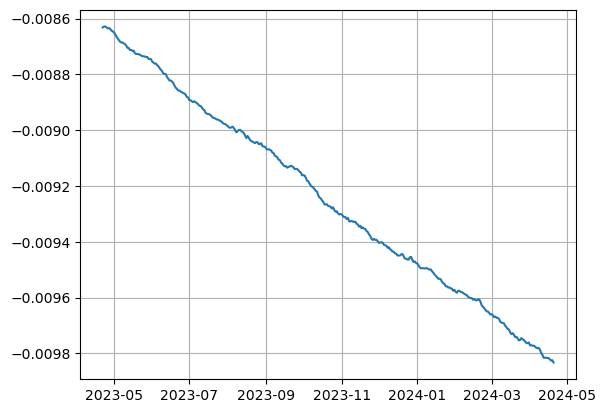

In [48]:
print("Apple")
precios_cierre_aapl=sim_R_aapl23.cumprod()*-0.008627
mean_aapl = precios_cierre_aapl.mean(axis=1)
plt.plot(mean_aapl)
plt.grid()

Walmart


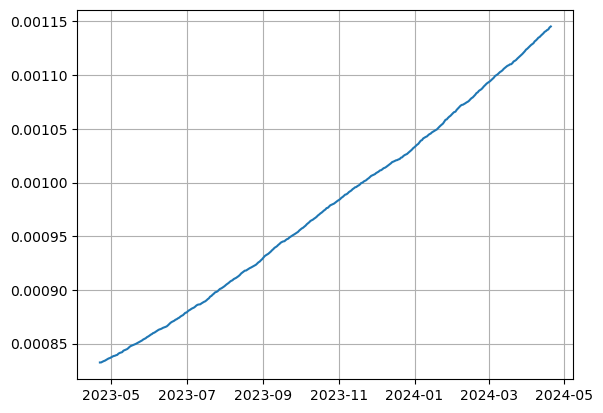

In [57]:
print("Walmart")
precios_cierre_wmt=sim_R_wmt23.cumprod()*0.000832
mean_wmt = precios_cierre_wmt.mean(axis=1)
plt.plot(mean_wmt)
plt.grid()

Autozone


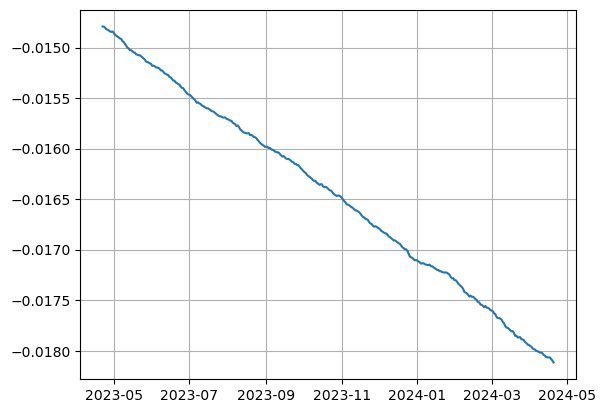

In [50]:
print("Autozone")
precios_cierre_azo=sim_R_azo23.cumprod()*-0.014780
mean_azo = precios_cierre_azo.mean(axis=1)
plt.plot(mean_azo)
plt.grid()

Occidental Petroleum


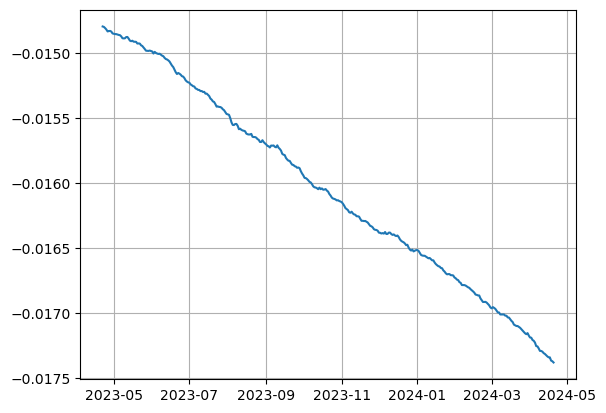

In [55]:
print("Occidental Petroleum")
precios_cierre_oxy=sim_R_oxy23.cumprod()*-0.014780
mean_oxy = precios_cierre_oxy.mean(axis=1)
plt.plot(mean_oxy)
plt.grid()

Ertex Pharmaceutics


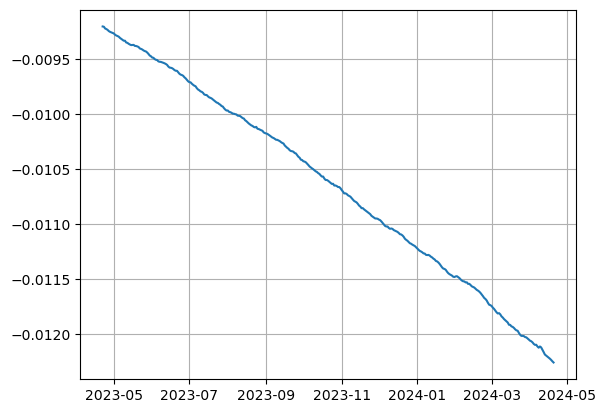

In [96]:
print("Ertex Pharmaceutics")
precios_cierre_vrtx=sim_R_vrtx23.cumprod()*-0.009195
mean_vrtx = precios_cierre_vrtx.mean(axis=1)
plt.plot(mean_vrtx)
plt.grid()

In [59]:
def getClose(names, start, end):
    return yf.download(names, start=start, end=end)[["Adj Close"]]

In [60]:
aapl=getClose("AAPL", "2023-04-22", "2024-04-22")
wmt=getClose("WMT", "2023-04-22", "2024-04-22")
azo=getClose("AZO", "2023-04-22", "2024-04-22")
oxy=getClose("OXY", "2023-04-22", "2024-04-22")
vrtx=getClose("VRTX", "2023-04-22", "2024-04-22")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [97]:
R_aapl=aapl.pct_change()
R_aapl.mean()
R_wmt=wmt.pct_change()
R_wmt.mean()
R_azo=azo.pct_change()
R_azo.mean()
R_oxy=oxy.pct_change()
R_oxy.mean()
R_vrtx=vrtx.pct_change()
R_vrtx.mean()

Adj Close    0.000791
dtype: float64

Apple


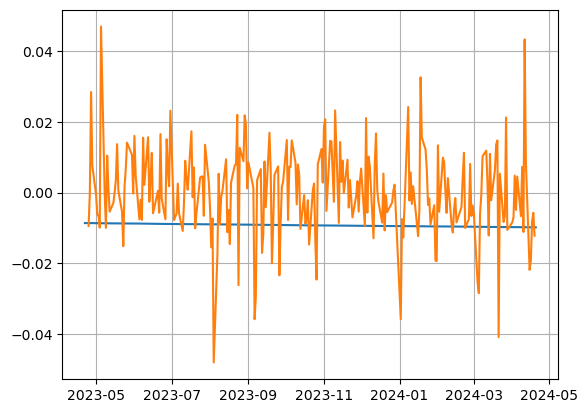

In [98]:
print("Apple")
plt.plot(mean_aapl)
plt.plot(R_aapl)
plt.grid()

Walmart


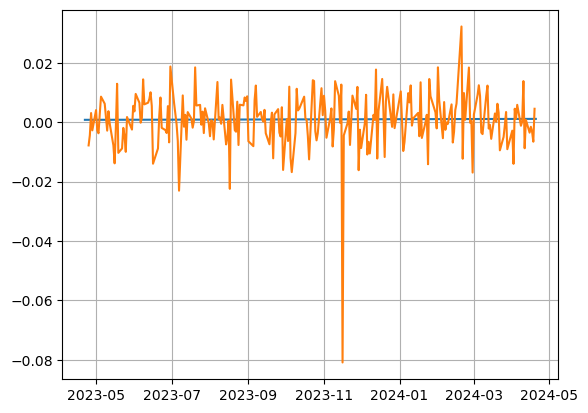

In [99]:
print("Walmart")
plt.plot(mean_wmt)
plt.plot(R_wmt)
plt.grid()

Amazon


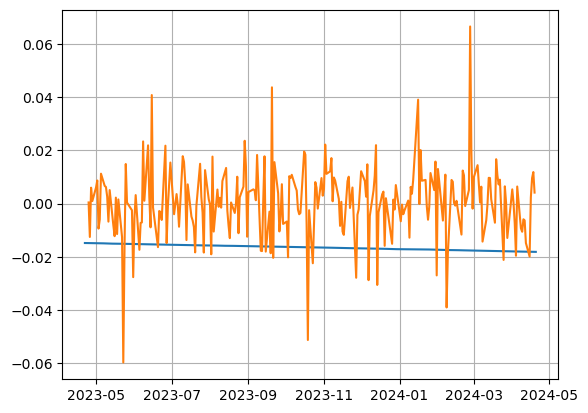

In [100]:
print("Amazon")
plt.plot(mean_azo)
plt.plot(R_azo)
plt.grid()

Occidental Petroleum


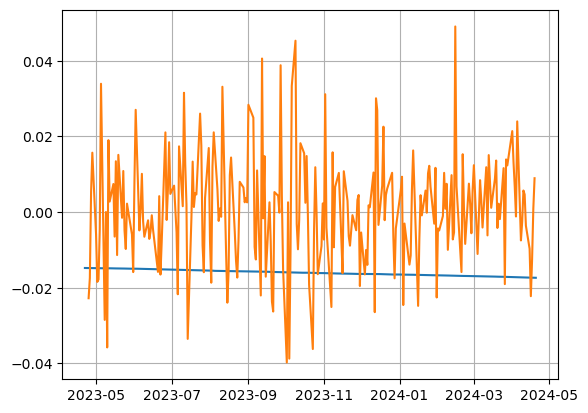

In [101]:
print("Occidental Petroleum")
plt.plot(mean_oxy)
plt.plot(R_oxy)
plt.grid()

Ertex Pharmaceutics


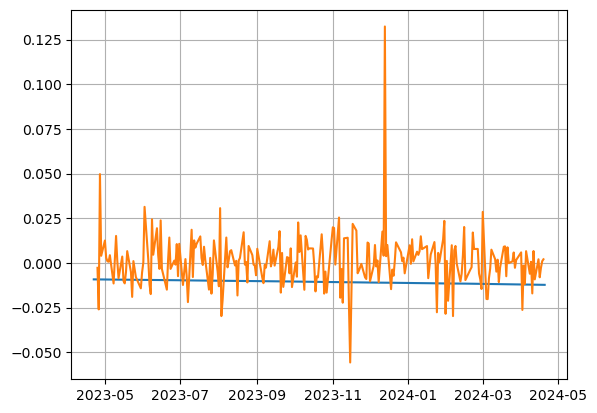

In [102]:
print("Ertex Pharmaceutics")
plt.plot(mean_vrtx)
plt.plot(R_vrtx)
plt.grid()

### Conclusiones.



### Referencias.

